In [4]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [5]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import msgpack
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import msgpack
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype

from src.common.AssetData import AssetData
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut


In [6]:
asset = AssetFileInOut("../src/database").loadFromFile('goog')  # Example ticker
asset2 = AssetFileInOut("../src/database").loadFromFile('acln.sw')  # Example ticker
strategy = StratBuyAndHold(target_ticker='goog')

asset2.shareprice.index

TypeError: StratBuyAndHold.__init__() got an unexpected keyword argument 'target_ticker'

In [7]:
import datetime

simulation = SimulatePortfolio(
        initialCash=10000,
        strategy=strategy,
        assets=[asset],
        startDate=pd.Timestamp(2010, 1, 1),
        endDate=pd.Timestamp(2020, 1, 1)
    )

In [20]:
# Run simulation
simulation.run()

# Analyze results
#analyzer = ResultAnalyzer(simulation.portfolio)
#analyzer.plot_portfolio_value()

a= simulation.portfolio.history
a["Date"]

0                             NaT
1                             NaT
2                             NaT
3                             NaT
4                             NaT
                   ...           
33912   2019-12-26 00:00:00+00:00
33913   2019-12-27 00:00:00+00:00
33914   2019-12-30 00:00:00+00:00
33915   2019-12-31 00:00:00+00:00
33916   2020-01-01 00:00:00+00:00
Name: Date, Length: 33917, dtype: datetime64[ns, UTC]

In [19]:
dates = pd.date_range(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), freq='B')
dates 

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=2609, freq='B')

In [40]:
pd.Timestamp('2023-01-03', tz='America/New_York')

Timestamp('2023-01-03 00:00:00-0500', tz='America/New_York')

In [8]:
asset.shareprice[asset.shareprice.index > pd.Timestamp('2019-01-03', tz='UTC')].index.min()

Timestamp('2019-01-03 00:00:00-0500', tz='America/New_York')

In [10]:
asset.shareprice.index[20]

Timestamp('2004-09-17 00:00:00-0400', tz='America/New_York')

In [50]:
(asset.shareprice.index[2].tz_convert(None) > pd.Timestamp('2004-08-22')) & (asset.shareprice.index[2].tz_convert(None) < pd.Timestamp('2004-08-24'))

True

In [52]:
type(asset.shareprice.index[2].tz_convert(None))

pandas._libs.tslibs.timestamps.Timestamp

In [65]:
import numpy as np
np.argmax(asset.shareprice.index > pd.Timestamp('2003-08-18', tz='UTC'))

0

Slope (m): 13.612903225806452
Intercept (c): -11.612903225806452


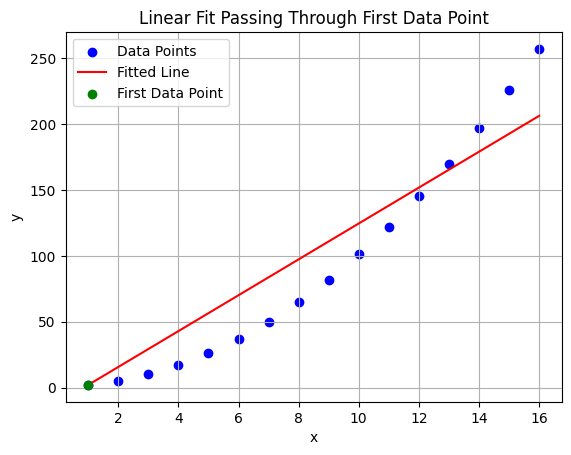

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fit_line_through_first_point(x, y):
    """
    Fits a linear curve to data points such that the line passes through
    the first data point and minimizes the residuals.

    Parameters:
    x (array-like): Independent variable data points.
    y (array-like): Dependent variable data points.

    Returns:
    m (float): Slope of the fitted line.
    c (float): Intercept of the fitted line.
    y_fit (ndarray): Fitted y-values corresponding to x.
    """
    x = np.array(x)
    y = np.array(y)
    x0 = x[0]
    y0 = y[0]
    dx = x - x0
    dy = y - y0

    denominator = np.sum(dx * dx)
    if denominator == 0:
        raise ValueError("Denominator is zero; all x values are the same.")
    m = np.sum(dx * dy) / denominator
    c = y0 - m * x0
    y_fit = m * x + c
    return m, c, y_fit

# Sample data points
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
y = (x ** 2) + 1

# Fit the line
m, c, y_fit = fit_line_through_first_point(x, y)

print(f"Slope (m): {m}")
print(f"Intercept (c): {c}")

# Plot the original data points
plt.scatter(x, y, color='blue', label='Data Points')

# Plot the fitted line
plt.plot(x, y_fit, color='red', label='Fitted Line')

# Highlight the first data point
plt.scatter(x[0], y[0], color='green', label='First Data Point', zorder=5)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Fit Passing Through First Data Point')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
